# Argo Section in region studied in Cole 2012

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import seaborn as sns
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw

import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import processing_funcs as prf

In [17]:
reload(ef);

## Section Selection

In [3]:
box = [-159,-157,22.75,34.5,0,2000]

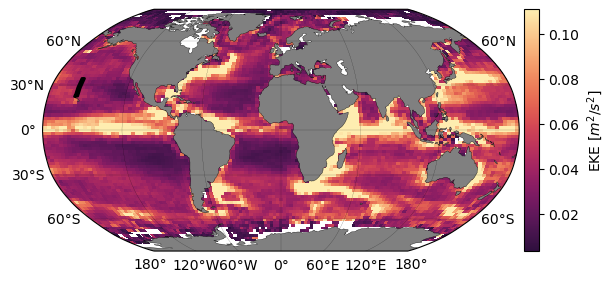

In [4]:
pf.plot_box([box])

In [13]:
scales = [50,100,200]
sample_max = 12
variables = ['CT','SA','SPICE']

In [18]:
sect = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-159,-157)_lat:(22.75,34.5)_ds_z.nc')

sect_EKEct = ef.get_EKE_da(sect, scales, sample_max, variables[0])
sect_EKEsa = ef.get_EKE_da(sect, scales, sample_max, variables[1])
sect_EKEsp = ef.get_EKE_da(sect, scales, sample_max, variables[2])

In [19]:
sect_SIG1 = gsw.density.sigma1(sect.SA, sect.CT)
sect = sect.assign(SIG1=(['N_PROF','PRES_INTERPOLATED'], sect_SIG1.data))

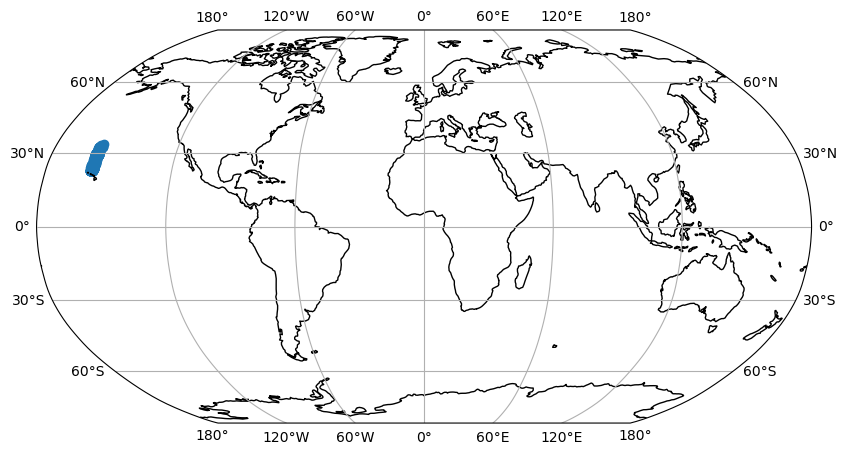

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()
ax.gridlines(draw_labels=True)
ax.scatter(sect.LONGITUDE,sect.LATITUDE,transform=ccrs.PlateCarree())

## T,S,SIG0,SPICE Sections

In [21]:
#        CT                     SA                      SIG0                    SPICE                CT gradient                   SA gradient                   Spice gradient
names = [cmo.thermal,           cmo.haline,             cmo.dense,              cmo.deep,            cmo.balance,                  cmo.balance,                  cmo.balance]
bounds = [np.linspace(-2,22,7), np.linspace(33,36.5,8), np.linspace(24,28.5,6), np.linspace(-2,5,7), np.linspace(-0.004,0.004,10), np.linspace(-0.004,0.004,10), np.linspace(-0.004,0.004,10)]
cmaps = []
norms = []

for n in range(0,len(names)):
    cmap = names[n]
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds[n], cmap.N)
    
    cmaps.append(cmap)
    norms.append(norm)

In [22]:
sect   = sect      .sortby('LATITUDE')#.where(sect6.sample_rate<sample_max)
EKE_ct = sect_EKEct.sortby('LATITUDE').where(sect_EKEct.mask==1).isel(EKE=1)
EKE_sa = sect_EKEsa.sortby('LATITUDE').where(sect_EKEsa.mask==1).isel(EKE=1)
EKE_sp = sect_EKEsp.sortby('LATITUDE').where(sect_EKEsp.mask==1).isel(EKE=1)

levels0  = np.linspace(sect.isel(PRES_INTERPOLATED=slice(500,1500)).SIG0.min(),sect.isel(PRES_INTERPOLATED=slice(500,1500)).SIG0.max(),6)
levels1  = np.linspace(sect.isel(PRES_INTERPOLATED=slice(500,1500)).SIG1.min(),sect.isel(PRES_INTERPOLATED=slice(500,1500)).SIG1.max(),6)

l1_ct = ff.get_filt_single(sect,scales[0],'CT')
l1_sa = ff.get_filt_single(sect,scales[0],'SA')
l1_sp = ff.get_filt_single(sect,scales[0],'SPICE')

l2_ct = ff.get_filt_single(sect,scales[1],'CT')
l2_sa = ff.get_filt_single(sect,scales[1],'SA')
l2_sp = ff.get_filt_single(sect,scales[1],'SPICE')

grad_ct = l2_ct.differentiate('PRES_INTERPOLATED')
grad_sa = l2_sa.differentiate('PRES_INTERPOLATED')
grad_sp = l2_sp.differentiate('PRES_INTERPOLATED')

In [23]:
lat_points = []
for n in range(0,len(sect.LATITUDE)):
    array = np.full(len(sect.PRES_INTERPOLATED),sect.LATITUDE.isel(N_PROF=n).values)
    lat_points.append(array)
    
sect = sect.assign_coords(lat_points=(['N_PROF','PRES_INTERPOLATED'],lat_points))

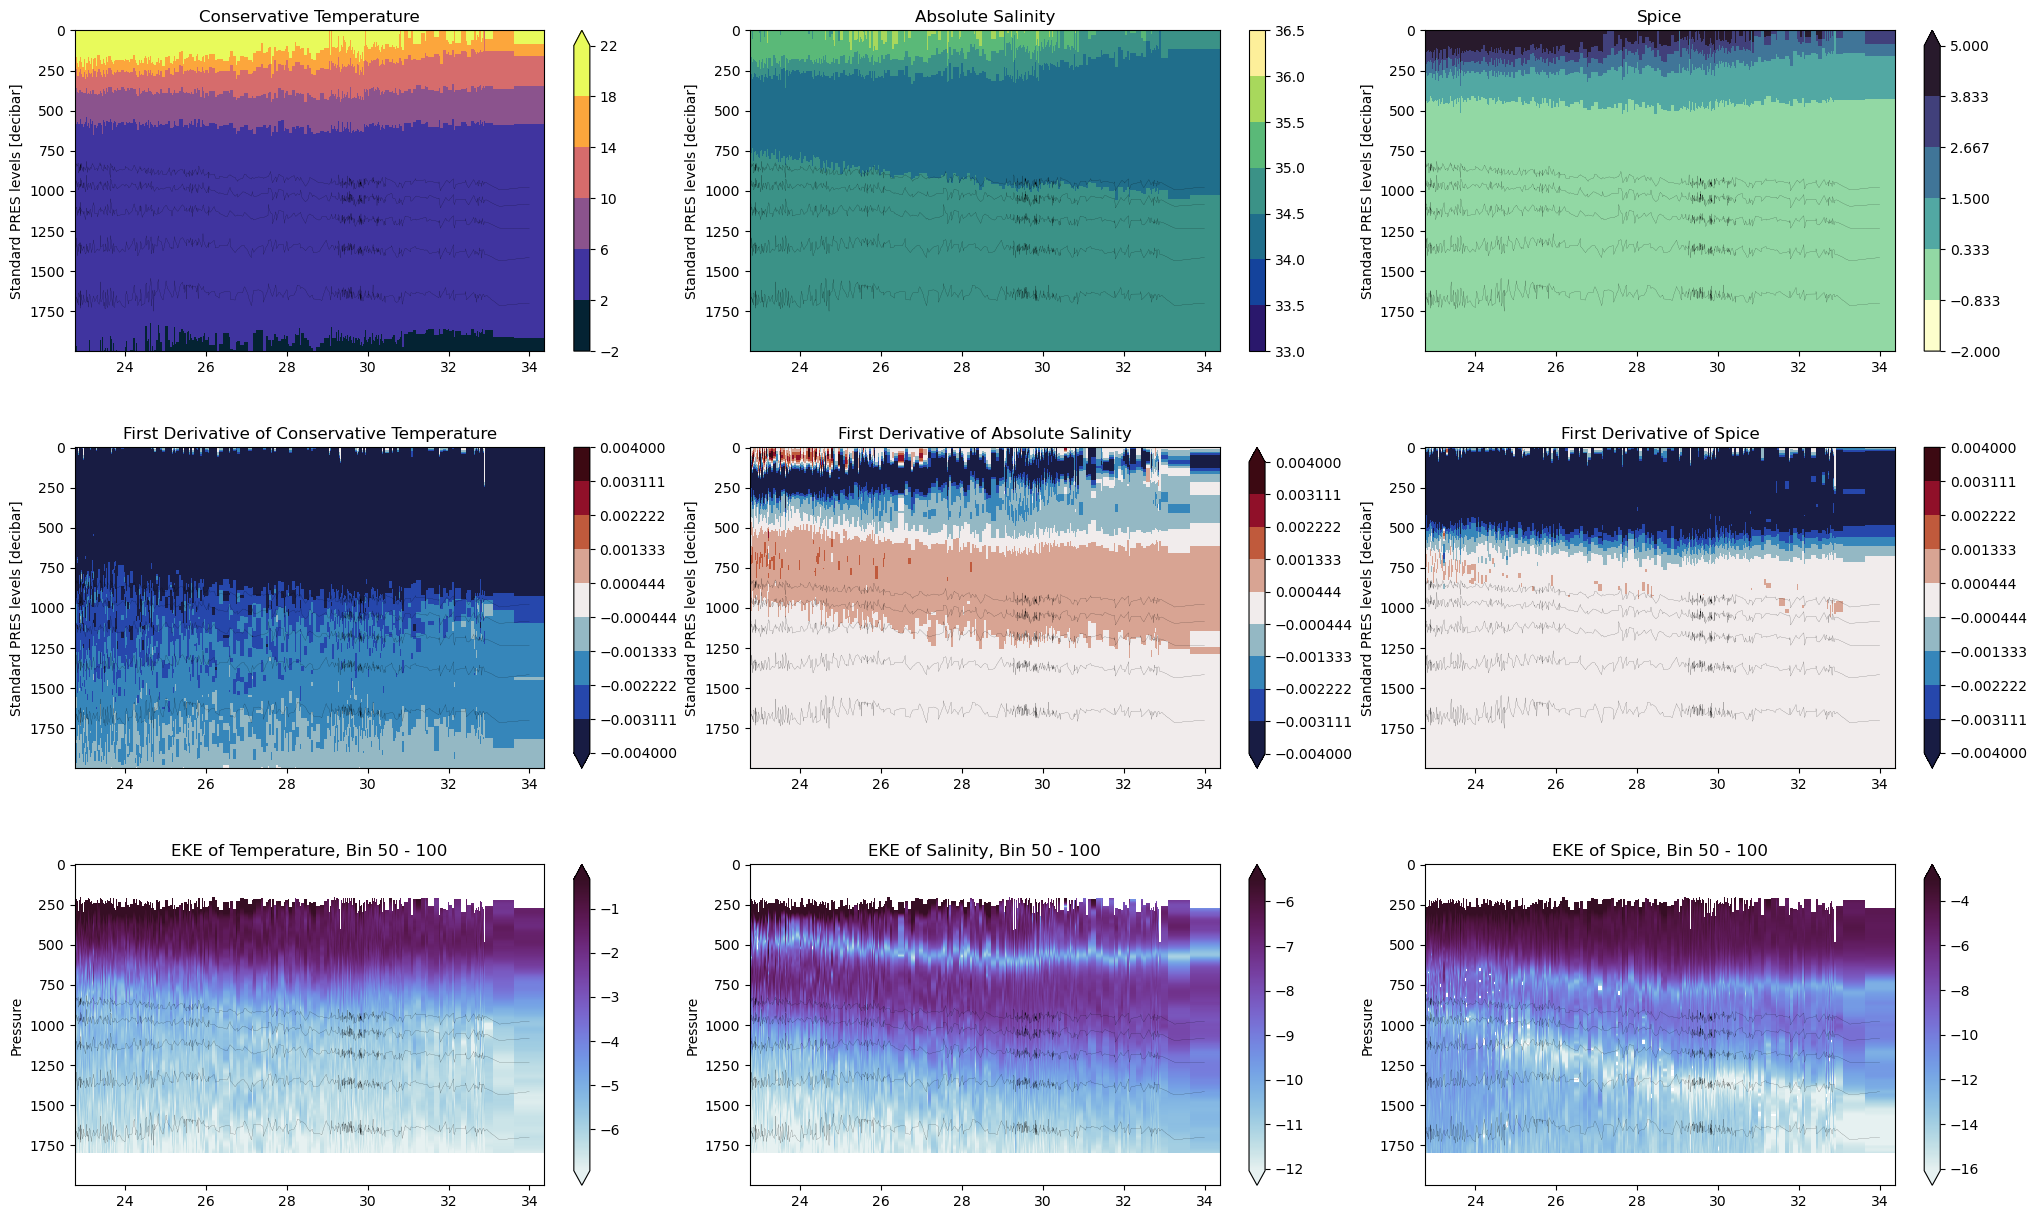

In [24]:
plt.figure(figsize=(25,15))

plt.subplot(331)
l2_ct.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[0], norm=norms[0])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
#sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('Conservative Temperature')

plt.subplot(332)
l2_sa.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[1], norm=norms[1])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('Absolute Salinity')

plt.subplot(333)
l2_sp.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[3], norm=norms[3])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('Spice')

plt.subplot(334)
grad_ct.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[4], norm=norms[4])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('First Derivative of Conservative Temperature')

plt.subplot(335)
grad_sa.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[5], norm=norms[5])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('First Derivative of Absolute Salinity')

plt.subplot(336)
grad_sp.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[6], norm=norms[6])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('First Derivative of Spice')

plt.subplot(337)
np.log(EKE_ct).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Pressure')
plt.title('EKE of Temperature, Bin {} - {}'.format(scales[0], scales[1]))

plt.subplot(338)
np.log(EKE_sa).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Pressure')
plt.title('EKE of Salinity, Bin {} - {}'.format(scales[0], scales[1]))

plt.subplot(339)
np.log(EKE_sp).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Pressure')
plt.title('EKE of Spice, Bin {} - {}'.format(scales[0], scales[1]))

plt.subplots_adjust(hspace=0.3, wspace=0.15)

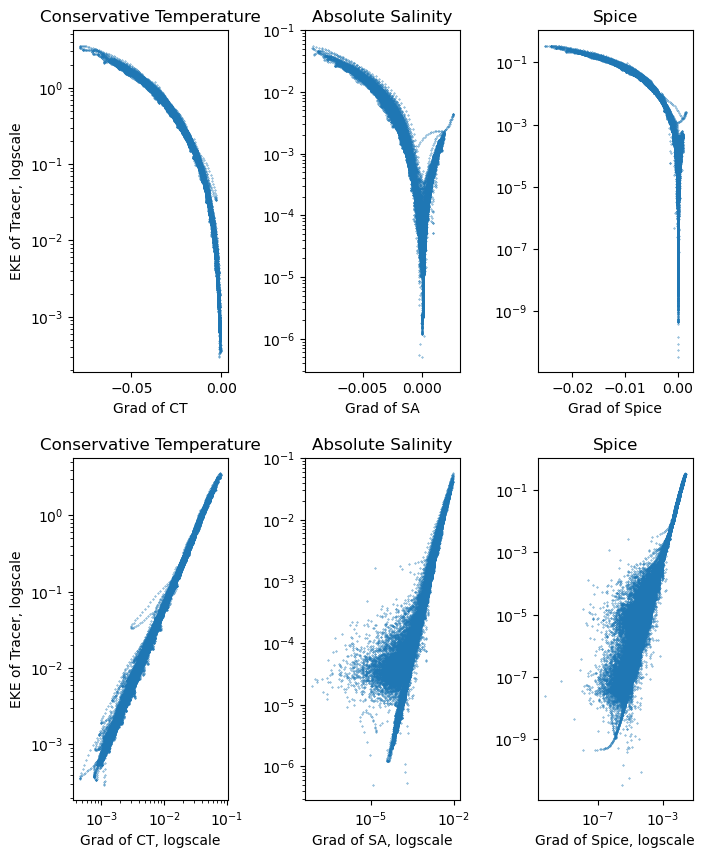

In [25]:
plt.figure(figsize=(8,10))

plt.subplot(231)
plt.scatter(grad_ct,EKE_ct,s=0.1,color='tab:blue')
plt.yscale('log')
plt.xlabel('Grad of CT')
plt.ylabel('EKE of Tracer, logscale')
plt.title('Conservative Temperature')

plt.subplot(232)
plt.scatter(grad_sa,EKE_sa,s=0.1,color='tab:blue')
plt.yscale('log')
plt.xlabel('Grad of SA')
plt.ylabel('')
plt.title('Absolute Salinity')

plt.subplot(233)
plt.scatter(grad_sp,EKE_sp,s=0.1,color='tab:blue')
plt.yscale('log')
plt.xlabel('Grad of Spice')
plt.ylabel('')
plt.title('Spice')

plt.subplot(234)
plt.scatter(np.abs(grad_ct),EKE_ct,s=0.1,color='tab:blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Grad of CT, logscale')
plt.ylabel('EKE of Tracer, logscale')
plt.title('Conservative Temperature')

plt.subplot(235)
plt.scatter(np.abs(grad_sa),EKE_sa,s=0.1,color='tab:blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Grad of SA, logscale')
plt.ylabel('')
plt.title('Absolute Salinity')

plt.subplot(236)
plt.scatter(np.abs(grad_sp),EKE_sp,s=0.1,color='tab:blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Grad of Spice, logscale')
plt.ylabel('')
plt.title('Spice')

plt.subplots_adjust(wspace=0.5, hspace=0.25)

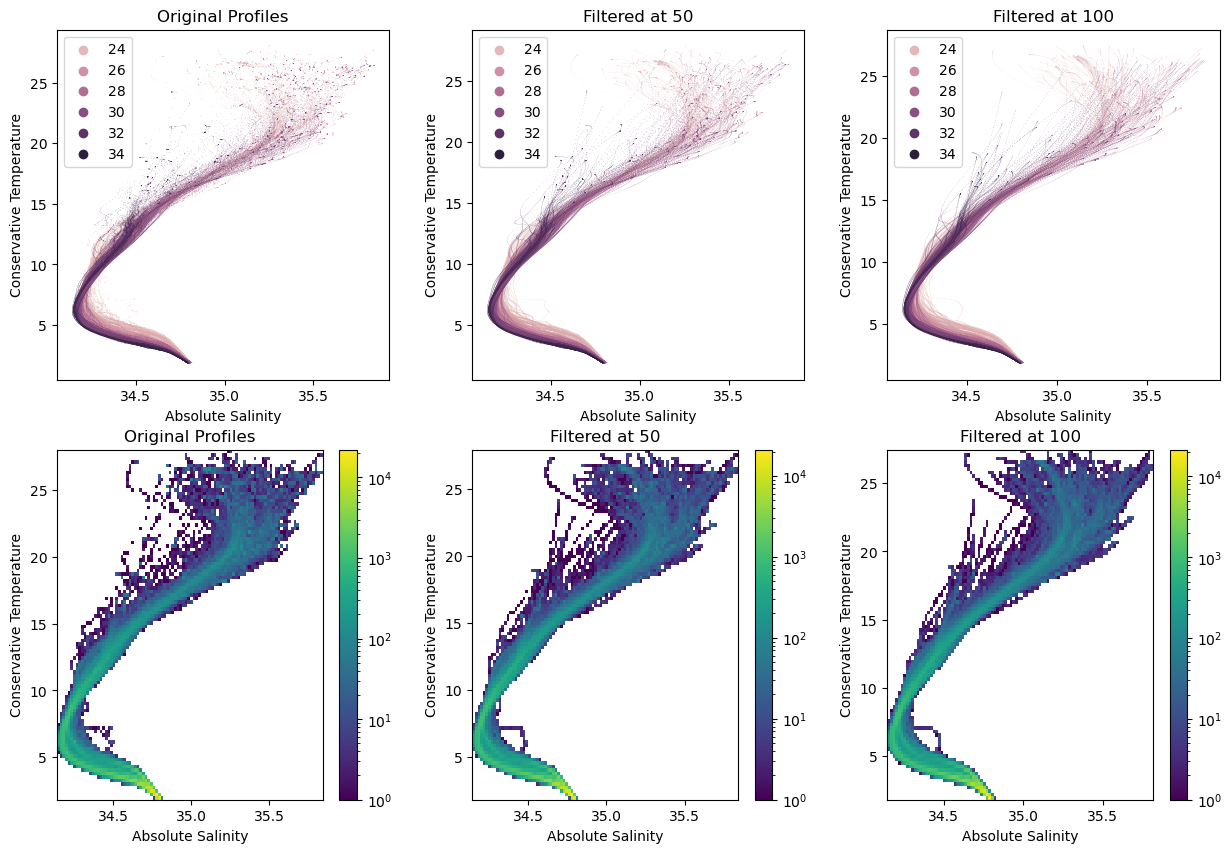

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(231)
sns.scatterplot(x=np.reshape(sect.SA.data,-1), y=np.reshape(sect.CT.data,-1), hue=np.reshape(sect.lat_points.data,-1), 
                linewidth=0, palette=sns.set_palette('flare',10),s=0.1)
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.title('Original Profiles')

plt.subplot(232)
sns.scatterplot(x=np.reshape(l1_sa.data,-1), y=np.reshape(l1_ct.data,-1), hue=np.reshape(sect.lat_points.data,-1), 
                linewidth=0, palette=sns.set_palette('flare',10),s=0.1)
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.title('Filtered at {}'.format(scales[0]))

plt.subplot(233)
sns.scatterplot(x=np.reshape(l2_sa.data,-1), y=np.reshape(l2_ct.data,-1), hue=np.reshape(sect.lat_points.data,-1), 
                linewidth=0, palette=sns.set_palette('flare',10),s=0.1)
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.title('Filtered at {}'.format(scales[1]))

plt.subplot(234)
plt.hist2d(np.reshape(sect.SA.data,-1),np.reshape(sect.CT.data,-1),bins=100,norm='log')
plt.colorbar()
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.title('Original Profiles')

plt.subplot(235)
plt.hist2d(np.reshape(l1_sa.data,-1),np.reshape(l1_ct.data,-1),bins=100,norm='log')
plt.colorbar()
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.title('Filtered at {}'.format(scales[0]))

plt.subplot(236)
plt.hist2d(np.reshape(l2_sa.data,-1),np.reshape(l2_ct.data,-1),bins=100,norm='log')
plt.colorbar()
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.title('Filtered at {}'.format(scales[1]))

plt.subplots_adjust(wspace=0.25)

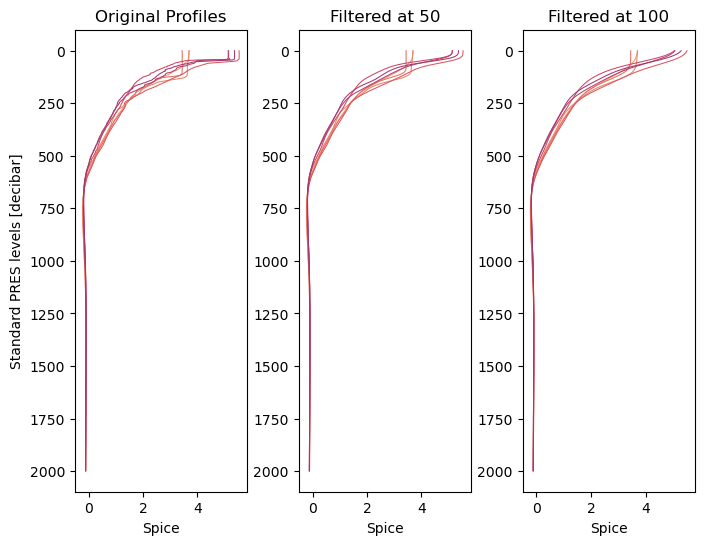

In [34]:
spice_or = sect.SPICE.where(sect.LATITUDE<30.1).where(sect.LATITUDE>30).dropna('N_PROF')
spice_l1 = l1_sp.where(l1_sp.LATITUDE<30.1).where(l1_sp.LATITUDE>30).dropna('N_PROF')
spice_l2 = l2_sp.where(l2_sp.LATITUDE<30.1).where(l2_sp.LATITUDE>30).dropna('N_PROF')

plt.figure(figsize=(8,6))
plt.subplot(131)
for n in range(0,len(spice_or)):
    spice_or[n].plot(y='PRES_INTERPOLATED',linewidth=0.75)
plt.xlabel('Spice')
plt.gca().invert_yaxis()
plt.title('Original Profiles')
    
plt.subplot(132)
for n in range(0,len(spice_or)):
    spice_l1[n].plot(y='PRES_INTERPOLATED',linewidth=0.75)
plt.xlabel('Spice')
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('Filtered at {}'.format(scales[0]))

plt.subplot(133)
for n in range(0,len(spice_or)):
    spice_l2[n].plot(y='PRES_INTERPOLATED',linewidth=0.75)
plt.xlabel('Spice')
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('Filtered at {}'.format(scales[1]))

plt.subplots_adjust(wspace=0.3)

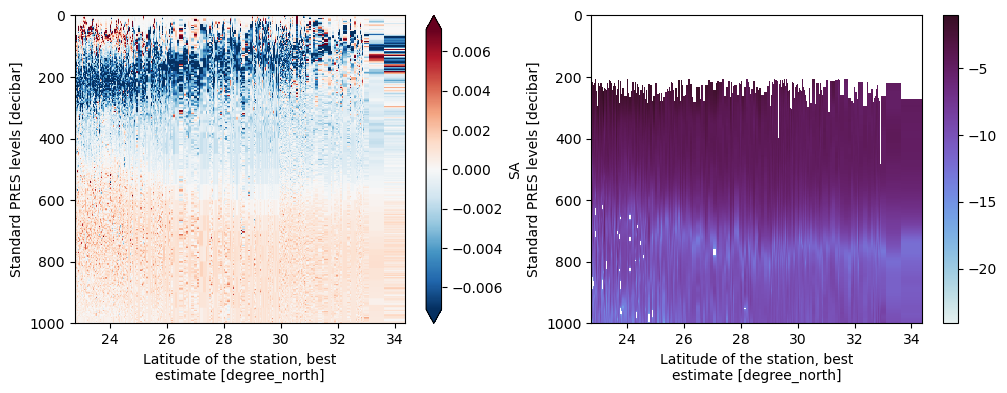

In [74]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sect.SA.differentiate('PRES_INTERPOLATED').plot(x='LATITUDE',y='PRES_INTERPOLATED',robust=True)
plt.ylim(1000,0)

plt.subplot(122)
np.log(EKE.isel(EKE=1)).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense)
plt.ylim(1000,0)

plt.subplots_adjust(wspace=0.25)